<a href="https://colab.research.google.com/github/JaeHeee/Paper_Review/blob/master/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 100
seed = np.random.uniform(-1,1, size = (8, 100))

In [0]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 # -1 ~ 1 로 바꿔준다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images.reshape(train_images.shape[0],784)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        
        self.input_layer = keras.layers.Dense(units = 784)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.2)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 =  keras.layers.LeakyReLU(alpha = 0.2)
        self.logits = keras.layers.Dense(units = 1)

    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.logits(x)
        return x


In [0]:
discriminator = Discriminator()

In [0]:
class Generator(keras.Model):
    
    def __init__(self, random_noise_size = 100):
        super().__init__(name='generator')
        self.input_layer = keras.layers.Dense(units = random_noise_size)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.2)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 =  keras.layers.LeakyReLU(alpha = 0.2)
        self.output_layer = keras.layers.Dense(units=784, activation = "tanh")
        
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.output_layer(x)
        return x
    
    def generate_noise(self,batch_size, random_noise_size):
        return np.random.uniform(-1,1, size = (batch_size, random_noise_size))


In [0]:
generator = Generator()

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def Discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

def Generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [0]:
discriminator_optimizer = keras.optimizers.Adam(0.0002,0.5)
generator_optimizer = keras.optimizers.Adam(0.0002,0.5)

In [0]:
@tf.function()
def training_step(generator: Generator, discriminator: Discriminator, images:np.ndarray, batch_size = BATCH_SIZE):
    noise = generator.generate_noise(batch_size, 100)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)

        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)

            
        disc_loss = Discriminator_loss(real_output, fake_output)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            
        gen_loss = Generator_loss(fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [0]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input,training=False)

    plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 8, i+1)
        plt.imshow(tf.reshape(predictions[i], shape = (28,28)), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [0]:
def train(dataset, epochs):
    for epoch in range(epochs+1):
        start = time.time()
        for image_batch in dataset:
            training_step(generator, discriminator, image_batch , batch_size=BATCH_SIZE)
        if (epoch % 10) == 0:
            print('Epoch:', str(epoch))
            print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))
            generate_and_save_images(generator,epoch,seed)

Epoch: 0
Time for epoch 0 is 3.314936637878418 sec


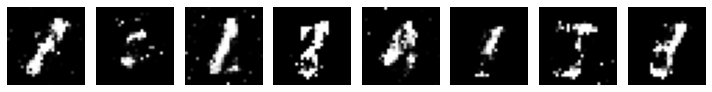

Epoch: 10
Time for epoch 10 is 1.8583135604858398 sec


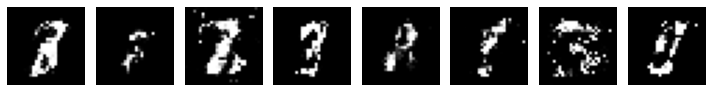

Epoch: 20
Time for epoch 20 is 1.88777756690979 sec


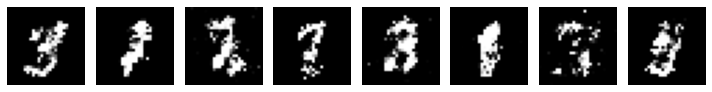

Epoch: 30
Time for epoch 30 is 1.9170262813568115 sec


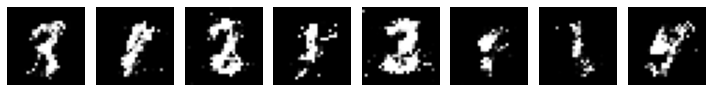

Epoch: 40
Time for epoch 40 is 1.9009959697723389 sec


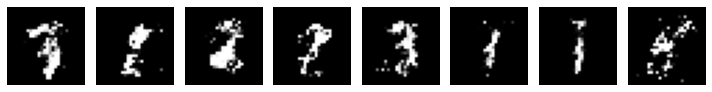

Epoch: 50
Time for epoch 50 is 1.889575719833374 sec


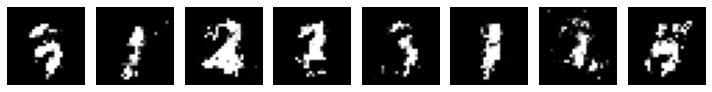

Epoch: 60
Time for epoch 60 is 1.9119269847869873 sec


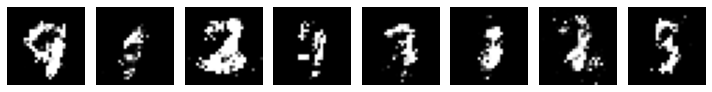

Epoch: 70
Time for epoch 70 is 1.8768894672393799 sec


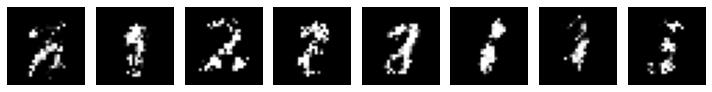

Epoch: 80
Time for epoch 80 is 1.8916804790496826 sec


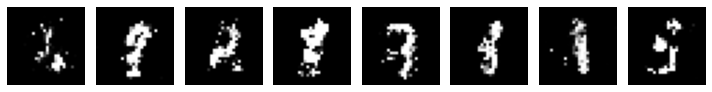

Epoch: 90
Time for epoch 90 is 1.903609037399292 sec


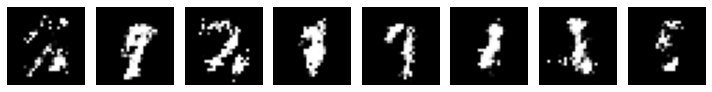

Epoch: 100
Time for epoch 100 is 1.908803939819336 sec


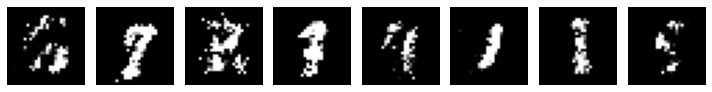

CPU times: user 3min 11s, sys: 16 s, total: 3min 27s
Wall time: 3min 17s


In [164]:
%%time
train(train_dataset, EPOCHS)